In [1]:
%load_ext autoreload
%autoreload 2
%load_ext tensorboard

In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

In [3]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import time
import json
import pprint

from PIL import Image
from IPython.display import display

import tensorflow as tf
from tensorflow.keras import layers, models

from get_frames import get_frames
from assemble_image import assemble_image
from get_labels import get_labels, get_windows_original, get_windows_encoded, image_windows_labels, get_defect_type
from load_image import load_image
from load_models import load_models

In [4]:
#gpu check
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [5]:
#load data image list
test_size = 0.1
stride_step = 50
norm_factor=1
dtype = 'uint8'

filename = f'save_data/e_d_test_all_str_50_ts_{test_size}_{dtype}_norm_{norm_factor}.pkl'
filename = f'save_data/e_d_train_all_str_50_ts_{test_size}_{dtype}_norm_{norm_factor}.pkl'

#load data
with open(filename, 'rb') as f:
    image_list,frames_data = pickle.load(f)
    
del frames_data

#image list
print('Image list:')
print('\n'.join([f'{i}: {image}' for i, image in enumerate(image_list)]))

Image list:
0: Fold1.png
1: Twist17.png
2: Fold18.png
3: Twist20.png
4: Fold14.png
5: Twist26.png
6: Fold8.png
7: Twist21.png
8: Fold10.png
9: Twist14.png
10: Fold22.png
11: Pucker9.png
12: Pucker21.png
13: Twist25.png
14: Pucker5.png
15: Pucker4.png
16: Fold17.png
17: Pucker32.png
18: Twist27.png
19: Pucker30.png
20: Twist28.png
21: Twist7.png
22: Twist18.png
23: Pucker28.png
24: Twist16.png
25: Twist1.png
26: Pucker11.png
27: Twist32.png
28: Fold15.png
29: Pucker15.png
30: Fold4.png
31: Pucker13.png
32: Twist30.png
33: Pucker2.png
34: Pucker12.png
35: Pucker22.png
36: Pucker14.png
37: Twist8.png
38: Pucker20.png
39: Fold7.png
40: Pucker6.png
41: Twist12.png
42: Twist5.png
43: Fold11.png
44: Fold5.png
45: Twist23.png
46: Twist11.png
47: Twist13.png
48: Fold19.png
49: Pucker10.png
50: Fold2.png
51: Pucker8.png
52: Twist9.png
53: Twist6.png
54: Pucker18.png
55: Twist29.png
56: Fold13.png
57: Twist24.png
58: Twist4.png
59: Fold12.png
60: Twist15.png
61: Twist19.png
62: Fold6.png
63: Twis

In [6]:
file_dict = {
    'Pucker':[],
    'Twist':[],
    'Fold':[]    
}
for image in image_list:
    for key in file_dict:
        if image[:4]==key[:4]:
            file_dict[key].append(image)
            break

In [7]:
ifSave = False
limit_right = 4001
limit_left = 0

borders_dict = {
    'Pucker9.png':[2800,3400],
    'Pucker21.png':[350,850],
    'Pucker5.png':[1800,2200],
    'Pucker4.png':[500,900],
    'Pucker32.png':[2150,2600],
    'Pucker30.png':[2900,3350],
    'Pucker28.png':[2600,2950],
    'Pucker11.png':[850,1300],
    'Pucker15.png':[2400,2800],
    'Pucker13.png':[1900,2400],
    'Pucker2.png':[900,1450],
    'Pucker12.png':[1200,1600],
    'Pucker22.png':[2500,3000],
    'Pucker14.png':[3100,3600],
    'Pucker20.png':[1050,1400],
    'Pucker6.png':[3500,3850],
    'Pucker10.png':[1750,2200],
    'Pucker8.png':[700,1150],
    'Pucker18.png':[3100,3550],
    'Pucker29.png':[750,1150],
    'Pucker25.png':[0,400],
    'Pucker27.png':[2150,2550],
    'Pucker17.png':[1100,1500],
    'Pucker1.png':[1750,2100],
    'Pucker19.png':[2750,3250],
    'Pucker31.png':[1400,1900],
    'Twist17.png':[1750,3600],
    'Twist20.png':[850,2700],
    'Twist26.png':[150,limit_right],
    'Twist21.png':[1300,3000],
    'Twist14.png':[750,limit_right],
    'Twist25.png':[300,limit_right],
    'Twist27.png':[1000,3150],
    'Twist28.png':[550,3100],
    'Twist7.png':[1150,3850],
    'Twist18.png':[1450,3100],
    'Twist16.png':[1200,3600],
    'Twist1.png':[550,3150],
    'Twist32.png':[1250,3050],
    'Twist30.png':[450,2400],
    'Twist8.png':[350,3050],
    'Twist12.png':[800,3250],
    'Twist5.png':[1500,3700],
    'Twist23.png':[1050,2950],
    'Twist11.png':[1000,3600],
    'Twist13.png':[1500,limit_right],
    'Twist9.png':[300,3000],
    'Twist6.png':[1350,3600],
    'Twist29.png':[1050,limit_right],
    'Twist24.png':[550,limit_right],
    'Twist4.png':[700,3500],
    'Twist15.png':[1300,3700],
    'Twist19.png':[1750,3350],
    'Twist22.png':[1300,2700],
    'Twist2.png':[1350,3200],
    'Twist3.png':[1200,3450],
    'Twist10.png':[1250,3650],
    'Pucker3.png':[2100,2550],
    'Pucker23.png':[3450,3850],
    'Pucker16.png':[850,1250],
    'Twist31.png':[0,1900],
    'Pucker7.png':[1300,1800],
    'Pucker26.png':[1650,2100],
    'Pucker24.png':[500,850]
}

#adding fold
#for fold defects go through the whole picture
#doesn't add all files
if 0:
    for file in file_dict['Fold']:
        borders_dict[file]=[limit_left,limit_right]
else:
    for i in range(1,23):
        file_name = f'Fold{i}.png'
        borders_dict[file_name]=[limit_left,limit_right]
    
if ifSave:
    file_name = f'defects_borders.json'
    folder = f'save_data/classify_data'  
    #create a folder if doesn't exist
    os.makedirs(folder, exist_ok=True)
    with open(f'{folder}/{file_name}', 'w') as f:
        json.dump(borders_dict, f)

[0, 4001]


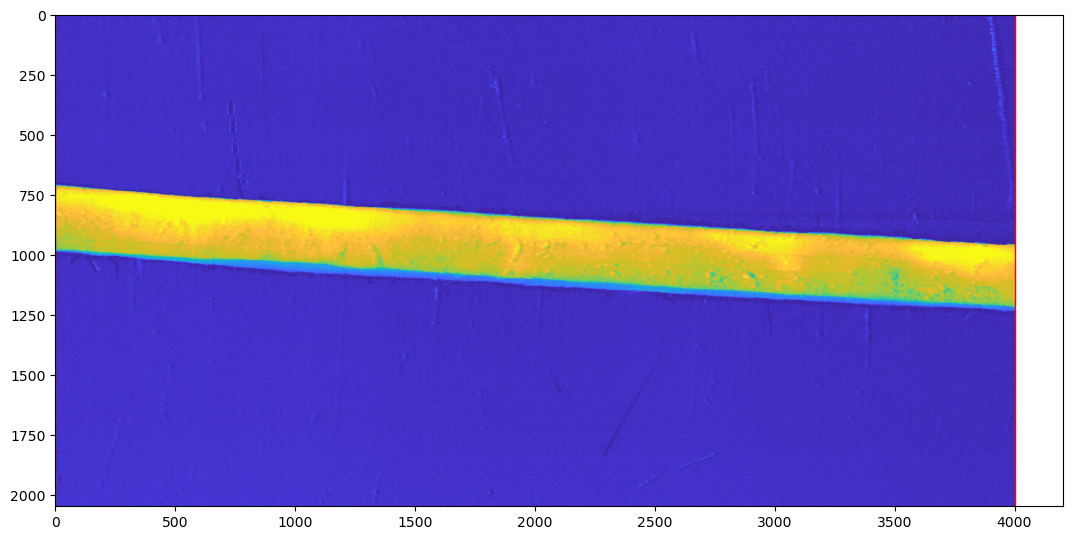

In [16]:
filename = 'Fold21.png'

image_data = load_image(filename)
plt.figure(figsize=(13,7))
plt.imshow(image_data)

linewidth=1

try: 
    borders_list = borders_dict[filename]
    print(borders_list)
    for border in borders_list:
        plt.axvline(x = border, color = 'red', linewidth=linewidth)
except KeyError:
    pass

In [8]:
#process all files
stride_step = 50
unit_numb = 5
lstm_type = 'win'

window_size = 6
window_size_predicted = 1
overlap = 0
repeat_prediction = 6
stateful = False

lstm_pars_dict = {
    'window_size':window_size,
    'window_size_predicted':window_size_predicted,
    'overlap':overlap,
    'repeat_prediction':repeat_prediction,
    'stateful':stateful,
    'lstm_type':lstm_type
}

padding_dict = {
    'ifPadding':True,
    'max_window_size':12,        
}

models_dict = load_models(unit_numb, stride_step, lstm_pars_dict)

windows_data_encoded_all = np.array([])
labels = np.array([])

for i, file_name in enumerate(image_list):
    print(file_name)
    borders_list = borders_dict[file_name]

    windows_data_encoded, labels = image_windows_labels(
        file_name,
        stride_step,
        borders_list,
        lstm_pars_dict,
        models_dict['model_encoder'],
        padding_dict
    )
    
    if i:
        windows_data_encoded_all = np.append(windows_data_encoded_all,windows_data_encoded,axis=0)
        labels_all = np.append(labels_all, labels, axis=0)
    else:
        windows_data_encoded_all = windows_data_encoded
        labels_all = labels

Fold21.png
Pucker3.png
Fold3.png
Pucker23.png
Pucker16.png


InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

In [15]:
labels.shape

(69,)

In [16]:
labels_all[-69:]

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0])

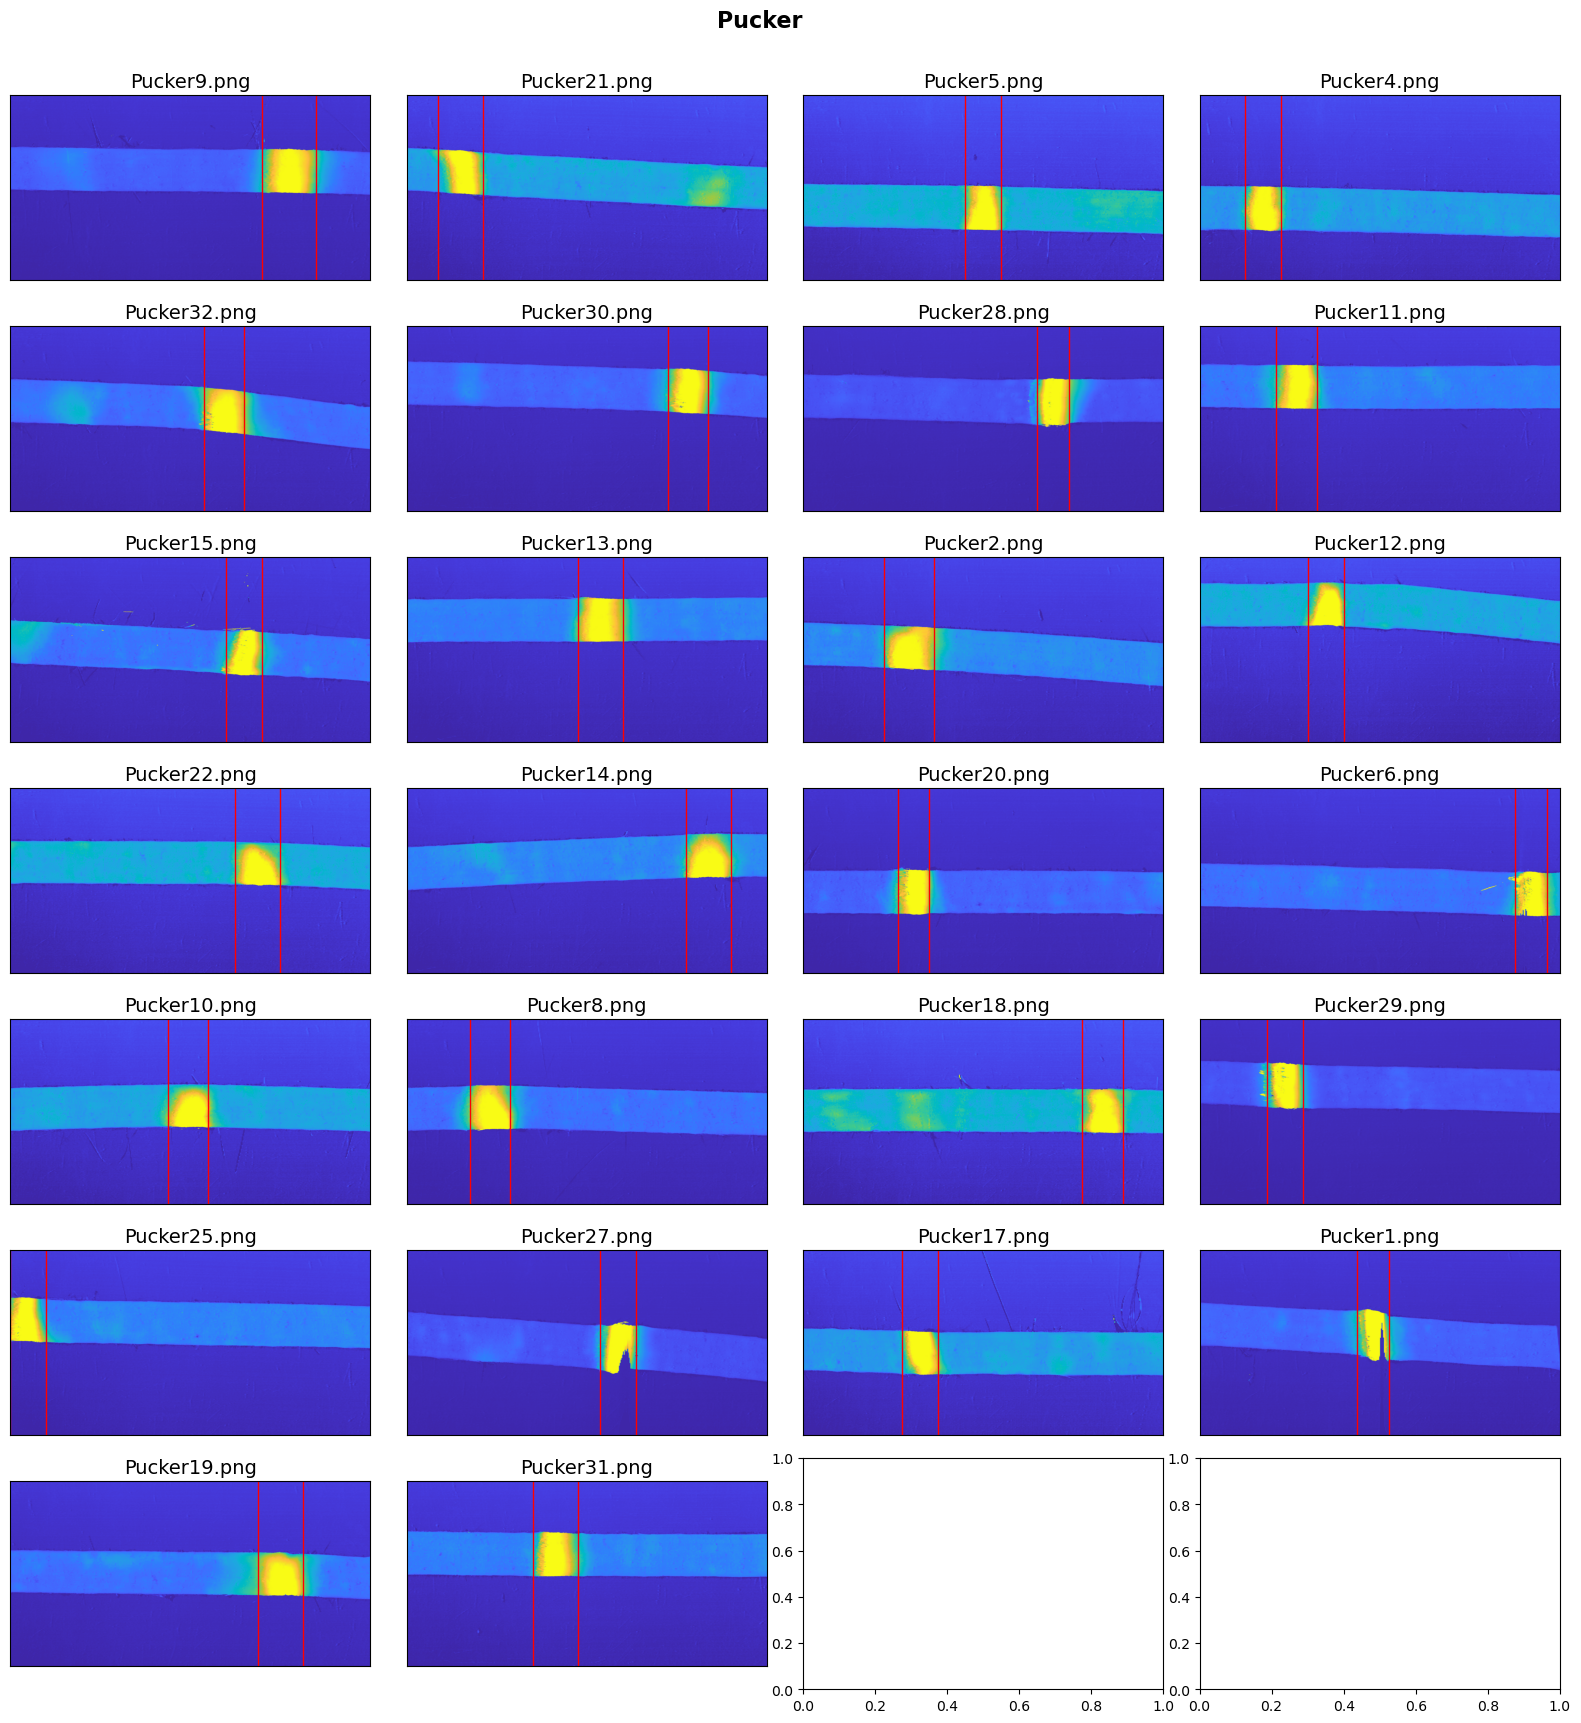

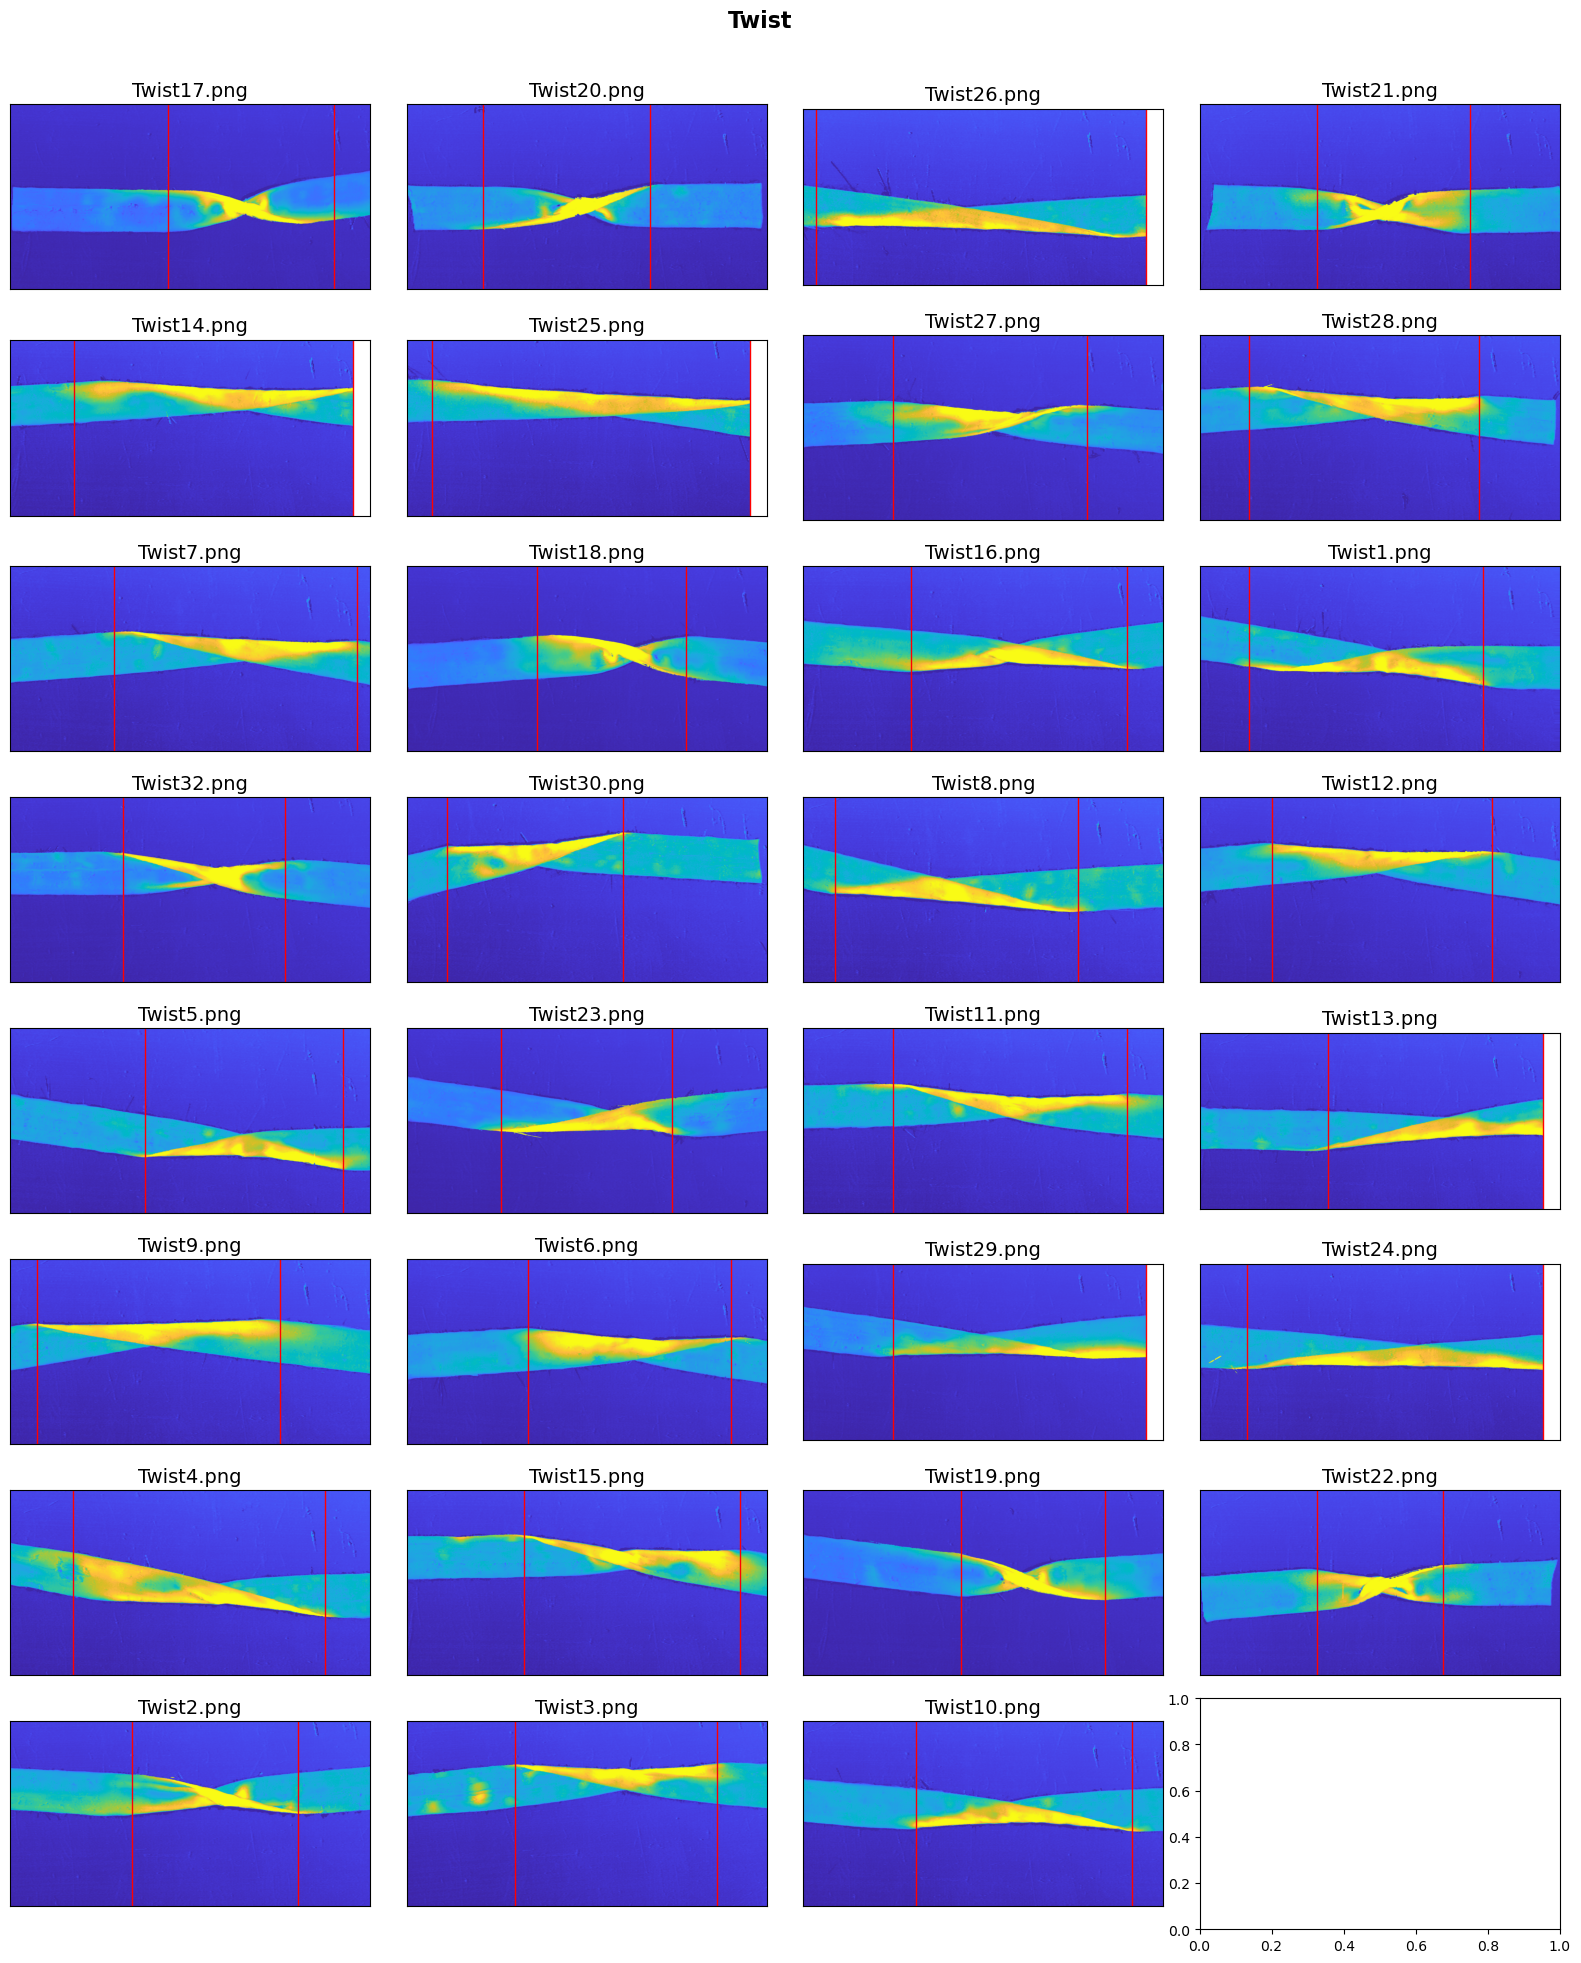

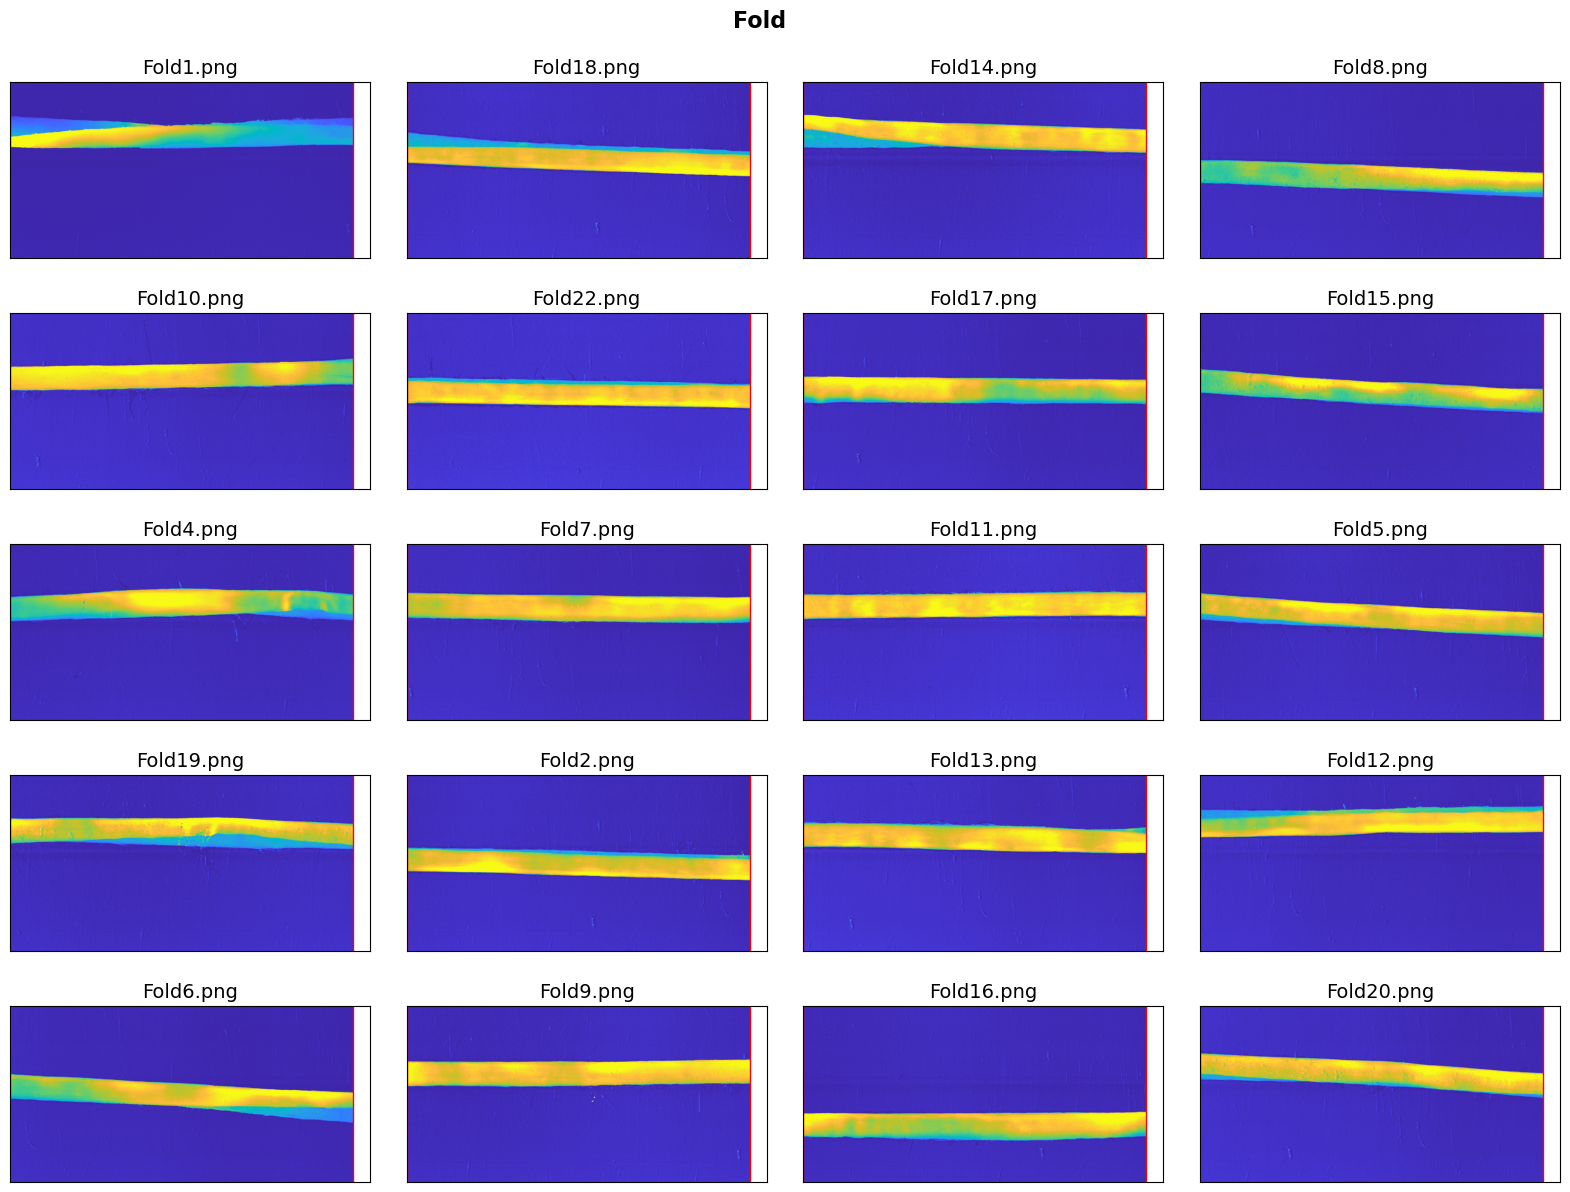

In [9]:
numb_cols = 4
dtype = 'uint8'

path_list = ['PuckerImages/RGB_cropped',
             'TwistImages/RGB',
             'FoldImages/RGB',]

for key in file_dict:
    file_list = file_dict[key]
    
    numb_rows = np.ceil(len(file_list)/numb_cols).astype('int')
    fig, axes = plt.subplots(numb_rows, numb_cols, figsize=(20,3*numb_rows))
    fig.subplots_adjust(hspace=0.0, wspace=0.1)
    linewidth = 1.0
    fontsize_sec = 14
    fig.suptitle(f'{key}', fontsize=fontsize_sec+2, fontweight='bold', y=0.91)
    
    for i, image in enumerate(file_list):
        for path in path_list:
            if image[:4]==path[:4]:
                break
        full_path = f'{path}/{image}'
        
        img = Image.open(full_path)
        image_data = np.array(img, dtype=dtype)
        #crop the end
        image_data = image_data[:,:-96,:]
                 
        ii = i//numb_cols
        jj = i%numb_cols
        
        ax = axes[ii, jj]
        ax.imshow(image_data)
        ax.set_title(f'{image}', fontsize=fontsize_sec)
        
        try: 
            borders_list = borders_dict[image]
            for border in borders_list:
                ax.axvline(x = border, color = 'red', linewidth=linewidth)
        except KeyError:
            pass
        
        ax.set_xticks([])
        ax.set_yticks([])
        
        
    save_folder='pictures/paper_pictures/'
    filename = f'class_{key}.png'
    #plt.savefig(f'{save_folder}/{filename}', bbox_inches='tight')

In [34]:
file_name = 'Twist10.png'

#process a single file
stride_step = 50
unit_numb = 5

window_size = 6
window_size_predicted = 1
overlap = 0
repeat_prediction = 4
stateful = False




lstm_pars_dict = {
    'window_size':window_size,
    'window_size_predicted':window_size_predicted,
    'overlap':overlap,
    'repeat_prediction':repeat_prediction,
    'stateful':stateful
}

padding_dict = {
    'ifPadding':True,
    'max_window_size':12,        
}

models_dict = load_models(unit_numb, stride_step, lstm_pars_dict)

borders_list = borders_dict[file_name]

windows_data_encoded, labels = image_windows_labels(
    file_name,
    stride_step,
    borders_list,
    lstm_pars_dict,
    models_dict['model_encoder'],
    padding_dict
)

In [35]:
#debug separate functions
file_name = 'Twist10.png'

padding_dict = {
    'ifPadding':True,
    'max_window_size':12,        
}


borders_list = borders_dict[file_name]
image_length = 4000
defect_type = get_defect_type(file_name)

image_data = load_image(filename)
image_data_frames = get_frames(image_data, stride_step, ifPrint = False)

#total size of a window used for classification
window_size_total = window_size + (window_size_predicted-overlap)*repeat_prediction

labels = get_labels(stride_step, borders_list, image_length, window_size_total, defect_type)
windows_data_original = get_windows_original(image_data_frames, stride_step, window_size_total,padding_dict)
windows_data_encoded = get_windows_encoded(windows_data_original, models_dict['model_encoder'])

Defect: 0


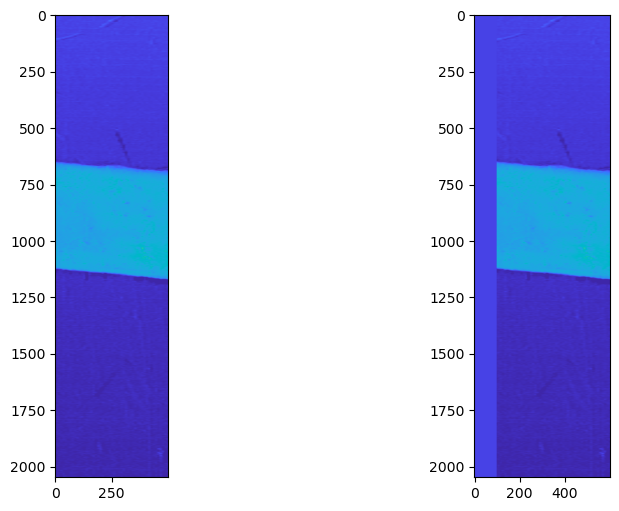

In [36]:
index = 2
print(f'Defect: {labels[index]}')

im_original_frame = assemble_image(image_data_frames[0+index:window_size_total+index])
im_split_frame = assemble_image(windows_data_original[index])

fig, axes = plt.subplots(1,2, figsize=(10,6))
fig.subplots_adjust(hspace=0.5, wspace=0.25)
linewidth = 3.0
fontsize_sec = 14

ax = axes[0]
ax.imshow(im_original_frame)

ax = axes[1]
ax.imshow(im_split_frame)

Defect: 0


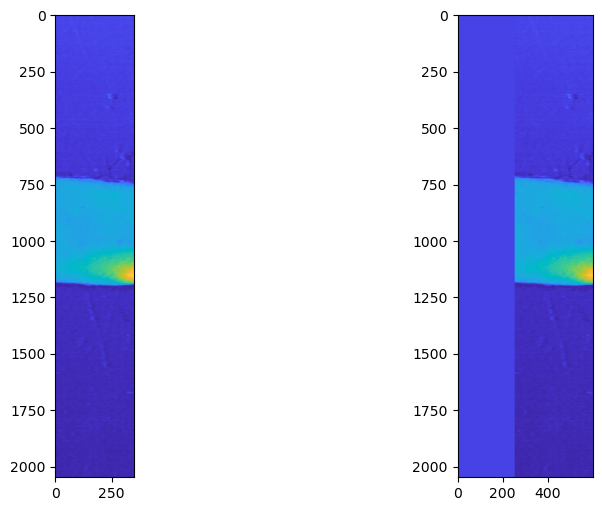

In [23]:
index = 18
print(f'Defect: {labels[index]}')

im_original_frame = assemble_image(image_data_frames[0+index:window_size_total+index])
im_split_frame = assemble_image(windows_data_original[index])

fig, axes = plt.subplots(1,2, figsize=(10,6))
fig.subplots_adjust(hspace=0.5, wspace=0.25)
linewidth = 3.0
fontsize_sec = 14

ax = axes[0]
ax.imshow(im_original_frame)

ax = axes[1]
ax.imshow(im_split_frame)

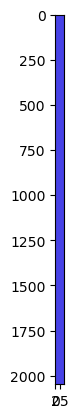

In [35]:
#padding
#pad value
pad_value = image_data[0,0] #top left pure blue colour array([ 71,  66, 230], dtype=uint8)
pad_shape = (image_data.shape[0], stride_step, image_data.shape[-1])
pad_image_original = np.full(pad_shape, pad_value)
plt.imshow(pad_image_original)

In [24]:
window_size_total_list = [8,9,10,11]
max_window_size = 12
for window_size_total in window_size_total_list:
    #padding
    #pad value
    pad_value = image_data[0,0] #top left pure blue colour
    nmb_pad_frames = max_window_size-window_size_total
    if nmb_pad_frames:
        pad_shape = (nmb_pad_frames,image_data.shape[0], stride_step, image_data.shape[-1])
        pad_image_original = np.full(pad_shape, pad_value)
        pad_image_encoded = models_dict['model_encoder'].predict(pad_image_original, verbose=0)
        print(pad_image_encoded.shape)
        print(pad_image_encoded)
        print('\n')

(4, 5)
[[0.17636827 0.42337987 0.34246257 0.46797806 0.48455012]
 [0.17636827 0.42337987 0.34246257 0.46797806 0.48455012]
 [0.17636827 0.42337987 0.34246257 0.46797806 0.48455012]
 [0.17636827 0.42337987 0.34246257 0.46797806 0.48455012]]


(3, 5)
[[0.17636831 0.42337987 0.34246215 0.4679779  0.4845504 ]
 [0.17636831 0.42337987 0.34246215 0.4679779  0.4845504 ]
 [0.17636831 0.42337987 0.34246215 0.4679779  0.4845504 ]]


(2, 5)
[[0.17632672 0.42336628 0.34245086 0.4679671  0.48459437]
 [0.17632672 0.42336628 0.34245086 0.4679671  0.48459437]]


(1, 5)
[[0.1763306  0.42336544 0.34244323 0.46795508 0.4846133 ]]


